Información del registro de ECG:
  - Frecuencia de muestreo: 500 Hz
  - Derivaciones disponibles: ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
  - Duración de la señal: 10.00 segundos

Visualizando la derivación 'II'...


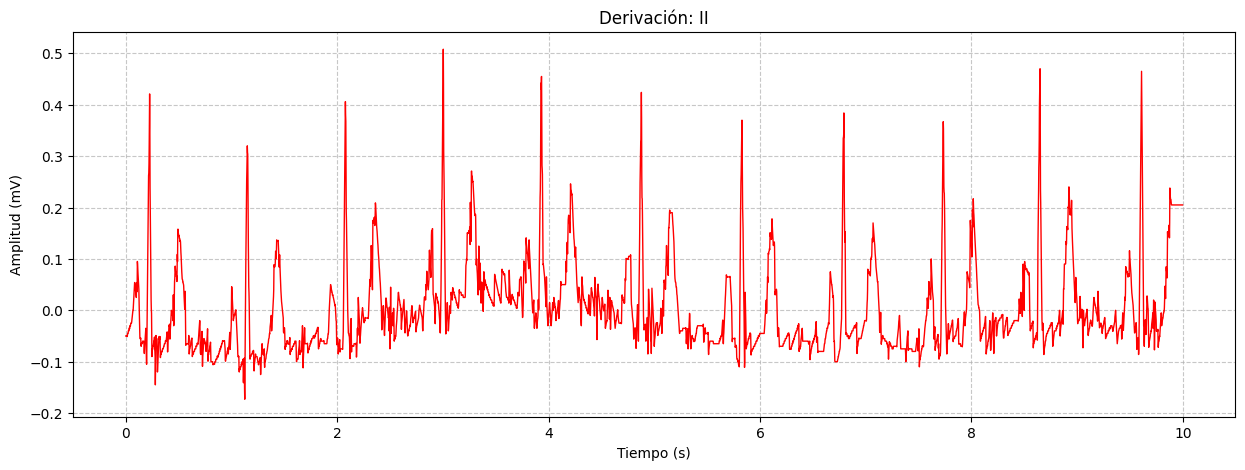

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from lecturaDatos import cargar_datos, visualizar_señal
# Definimos la ruta a nuestros datos en crudo
# La ruta es relativa a la ubicación del notebook
#ruta_datos = '../data/raw/record_1.dat'
ruta_datos = '../data/raw/records500/00000/00001_hr'

# Cargamos los datos del ECG
registro_ecg = cargar_datos(ruta_datos)

# Mostramos información básica del registro
print("Información del registro de ECG:")
print(f"  - Frecuencia de muestreo: {registro_ecg.fs} Hz")
print(f"  - Derivaciones disponibles: {registro_ecg.sig_name}")
print(f"  - Duración de la señal: {len(registro_ecg.p_signal) / registro_ecg.fs:.2f} segundos")

# Visualizamos una de las derivaciones (por ejemplo, la segunda, con índice 1)
print("\nVisualizando la derivación 'II'...")
visualizar_señal(registro_ecg, derivacion_idx=1)

In [3]:
# Visualizacion de los Datos de la Matriz
# Importamos la librería pandas
import pandas as pd

# Creamos un DataFrame de Pandas a partir de la matriz de la señal
# Las columnas serán los nombres de las derivaciones
df = pd.DataFrame(registro_ecg.p_signal, columns=registro_ecg.sig_name)

# Mostramos las primeras 10 filas de la matriz
print("Mostrando las primeras 10 filas de la matriz de datos:")
df.head(100)

Mostrando las primeras 10 filas de la matriz de datos:


,I,II,III,AVR,AVL,AVF,V1,V2,V3,V4,V5,V6
0,-0.115,-0.050,0.065,0.082,-0.090,0.007,-0.065,-0.040,-0.005,-0.035,-0.035,-0.075
1,-0.115,-0.050,0.065,0.082,-0.090,0.007,-0.065,-0.040,-0.005,-0.035,-0.035,-0.075
2,-0.115,-0.050,0.065,0.082,-0.090,0.007,-0.065,-0.040,-0.005,-0.035,-0.035,-0.075
3,-0.115,-0.050,0.065,0.082,-0.090,0.007,-0.065,-0.040,-0.005,-0.035,-0.035,-0.075
4,-0.115,-0.050,0.065,0.082,-0.090,0.007,-0.065,-0.040,-0.005,-0.035,-0.035,-0.075
...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.145,-0.035,0.110,0.090,-0.127,0.037,-0.035,-0.025,-0.035,-0.025,-0.050,-0.080
96,-0.159,-0.049,0.110,0.104,-0.134,0.030,-0.022,-0.006,-0.035,-0.030,-0.051,-0.079
97,-0.185,-0.075,0.110,0.130,-0.147,0.017,-0.015,0.017,-0.033,-0.030,-0.046,-0.091
98,-0.214,-0.104,0.110,0.159,-0.162,0.003,-0.003,0.030,-0.040,-0.048,-0.063,-0.123
